# Taller 2 - Ciencia de Datos Aplicada

Juan Diego Ospina Aguirre - 201814547
  
**Dataset:** dataset construido por la organización Gapminder (https://www.gapminder.org/data/), quienes han hecho la labor de, a partir de múltiples fuentes, integrar indicadores por país para un periodo aproximado de tiempo.

**Business Context:** El Producto Interno Bruto (PIB) ha sido uno de los indicadores clave para
evaluar la capacidad de pago de un país. Sin embargo, si bien existen reportes anuales del
PIB de los países, aún no se entiende a la perfección con qué otros indicadores como tasa
de empleo, acceso a internet, expectativa de vida, entre otros, se encuentra relacionado. Mediante el uso de modelos de regresión lineal, en conjunto con técnicas de preparación y
exploración de datos, se espera que usted esté en capacidad de extraer y entender las
relaciones que puedan existir entre el PIB de un país y otros indicadores disponibles.


In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [140]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

## 1. Carga y entendimiento de los datos

Con base en el diccionario proporcionado de la data, se creará una lista con los nuevos nombres de los campos, para realizar un desarrollo mucho más sencillo

In [11]:
columns = ["country"
          ,"pib_per_person"
          ,"alcohol_consumption_per_person"
          ,"perc_armed_force"
          ,"perc_brest_cancer"
          ,"co2_emissions"
          ,"perc_female_employ"
          ,"perc_VIH"
          ,"perc_users_with_internet"
          ,"life_expectancy"
          ,"oil_per_person"
          ,"polity_score"
          ,"electric_consumption_per_person"
          ,"perc_suicide"
          ,"perc_employ"
          ,"perc_urban"]

In [12]:
df = pd.read_csv("./data/gapminder_final.csv", header=0, names=columns)

In [13]:
df.shape

(178, 16)

In [14]:
df.dtypes

country                             object
pib_per_person                     float64
alcohol_consumption_per_person     float64
perc_armed_force                   float64
perc_brest_cancer                  float64
co2_emissions                      float64
perc_female_employ                 float64
perc_VIH                           float64
perc_users_with_internet           float64
life_expectancy                    float64
oil_per_person                     float64
polity_score                       float64
electric_consumption_per_person    float64
perc_suicide                       float64
perc_employ                        float64
perc_urban                         float64
dtype: object

In [15]:
df.head()

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_VIH,perc_users_with_internet,life_expectancy,oil_per_person,polity_score,electric_consumption_per_person,perc_suicide,perc_employ,perc_urban
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,0.2,69.770394,80.557,1.700262,10.0,2051.802338,10.365070,59.900002,61.34
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,NaN,44.989947,76.918,NaN,9.0,636.341383,7.699330,51.400002,46.72
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,4.7,2.300027,48.398,NaN,-1.0,NaN,13.548420,71.300003,38.58
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,1.4,70.028599,76.835,NaN,NaN,NaN,3.108603,66.900002,39.84
4,Italy,18982.269290,9.72,1.729346,74.4,1.900045e+10,35.799999,0.3,53.740217,81.855,1.207250,10.0,1176.385457,4.930045,46.400002,68.08


Cómo aún no tenemos ninguna información adicional sobre las features, y tampoco contamos con contexto adicional, comenzaremos realizando un análisis para determinar cuáles features son las más relevantes para el problema.

In [16]:
df["country"].nunique()

166

In [19]:
df.loc[df["country"].duplicated(keep=False)].sort_values("country", ascending=True)

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_VIH,perc_users_with_internet,life_expectancy,oil_per_person,polity_score,electric_consumption_per_person,perc_suicide,perc_employ,perc_urban
148,Belarus,2737.670379,18.85,3.711930,36.0,9.998743e+08,48.599998,0.3,32.052144,70.349,0.687828,-7.0,614.907287,26.874690,53.400002,73.46
27,Belarus,2737.670379,18.85,3.711930,36.0,9.998743e+08,48.599998,0.3,32.052144,70.349,0.687828,-7.0,614.907287,26.874690,53.400002,73.46
124,Iran,2161.546510,1.03,2.026400,17.1,9.183548e+09,26.900000,0.2,13.000111,72.974,1.162576,-7.0,753.209802,6.021882,47.799999,68.46
116,Iran,2161.546510,1.03,2.026400,17.1,9.183548e+09,26.900000,0.2,13.000111,72.974,1.162576,-7.0,753.209802,6.021882,47.799999,68.46
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,0.2,69.770394,80.557,1.700262,10.0,2051.802338,10.365070,59.900002,61.34
155,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,0.2,69.770394,80.557,1.700262,10.0,2051.802338,10.365070,59.900002,61.34
143,Lithuania,5332.238591,16.30,1.487831,38.5,2.262553e+08,48.799999,0.1,62.811900,72.231,0.812369,10.0,758.858719,33.341860,53.099998,66.96
25,Lithuania,5332.238591,16.30,1.487831,38.5,2.262553e+08,48.799999,0.1,62.811900,72.231,0.812369,10.0,758.858719,33.341860,53.099998,66.96
97,Luxembourg,52301.587180,12.84,0.731336,82.5,5.920127e+08,45.900002,0.3,90.079527,79.963,NaN,NaN,1566.106139,12.405918,53.500000,82.44
166,Luxembourg,52301.587180,12.84,0.731336,82.5,5.920127e+08,45.900002,0.3,90.079527,79.963,NaN,NaN,1566.106139,12.405918,53.500000,82.44


Como podemos observar, hay algunos países que tienen toda la data duplicada, por lo que es necesario eliminar estos duplicados

In [21]:
df = df.drop_duplicates()

In [22]:
df.shape

(166, 16)

In [23]:
df["country"].nunique()

166

Análisis de correlaciones

In [28]:
correlation_matrix = df.corr()
correlation_with_pib = correlation_matrix['pib_per_person'].sort_values(ascending=False)
correlation_with_pib


pib_per_person                     1.000000
perc_users_with_internet           0.808128
perc_brest_cancer                  0.730466
electric_consumption_per_person    0.664379
life_expectancy                    0.606281
perc_urban                         0.585350
oil_per_person                     0.542281
co2_emissions                      0.316875
alcohol_consumption_per_person     0.291129
polity_score                       0.287579
perc_female_employ                 0.019218
perc_armed_force                   0.015255
perc_suicide                       0.005159
perc_employ                       -0.011747
perc_VIH                          -0.201640
Name: pib_per_person, dtype: float64

In [29]:
correlation_with_pib[1:6]

perc_users_with_internet           0.808128
perc_brest_cancer                  0.730466
electric_consumption_per_person    0.664379
life_expectancy                    0.606281
perc_urban                         0.585350
Name: pib_per_person, dtype: float64

De esta manera, podemos determinar que los 5 indicadores más relevantes o más influyentes a priori para el PIB son:
- Internetuserate
- Breastcancerper100TH
- Relectricperperson
- Lifeexpectancy
- Urbanrate

Con el fin de realizar un análisis mucho más robusto, se investigó en la página de gapminder y se descargaron los datos de 5 indicadores más para ver si tienen alguna mayor correlación que las features anteriores.

In [274]:
gini_coefficient = pd.read_csv("./data/gini_2100.csv")
corruption_index = pd.read_csv("./data/corruption_perception_index_cpi_pre2012.csv")
perc_unemployment = pd.read_csv("./data/aged_15plus_unemployment_rate_percent.csv")
population_density = pd.read_csv("./data/population_density_per_square_km.csv")
owid_education_index = pd.read_csv("./data/owid_education_idx.csv")
population = pd.read_csv("./data/pop.csv")

In [275]:
gini_coefficient = gini_coefficient[['country','2010']]
corruption_index = corruption_index[['country','2010']]
perc_unemployment = perc_unemployment[['country','2010']]
population_density = population_density[['country','2010']]
owid_education_index = owid_education_index[['country','2010']]
population = population[['country','2010']]

In [276]:
population

,country,2010
0,Afghanistan,28.2M
1,Angola,23.4M
2,Albania,2.91M
3,Andorra,71.5k
4,UAE,8.48M
5,Argentina,41.1M
6,Armenia,2.95M
7,Antigua and Barbuda,85.7k
8,Australia,22M
9,Austria,8.36M


In [277]:
population['2010_new'] = population['2010'].str.slice(0, -1)
population['2010_new'] = population['2010_new'].astype(float)
population['2010_factor'] = population['2010'].str[-1]

def multiplicar(row):
    if row['2010_factor'] == "k":
        return row['2010_new'] * 1000
    elif row['2010_factor'] == "M":
        return row['2010_new'] * 1000000
    elif row['2010_factor'] == "B":
        return row['2010_new'] * 1000000000000
    
population['2010_final'] = population.apply(multiplicar, axis=1)
population = population.drop(columns=['2010', '2010_new', '2010_factor'])
population

,country,2010_final
0,Afghanistan,2.820000e+07
1,Angola,2.340000e+07
2,Albania,2.910000e+06
3,Andorra,7.150000e+04
4,UAE,8.480000e+06
5,Argentina,4.110000e+07
6,Armenia,2.950000e+06
7,Antigua and Barbuda,8.570000e+04
8,Australia,2.200000e+07
9,Austria,8.360000e+06


In [278]:
gini_coefficient = gini_coefficient.rename(columns={'2010': 'gini_coefficient'})
corruption_index = corruption_index.rename(columns={'2010': 'corruption_index'})
perc_unemployment = perc_unemployment.rename(columns={'2010': 'perc_unemployment'})
population_density = population_density.rename(columns={'2010': 'population_density'})
owid_education_index = owid_education_index.rename(columns={'2010': 'owid_education_index'})
population = population.rename(columns={'2010_final': 'population'})

print(len(population_density))
population_density = population_density[~population_density['country'].isin(["Macao, China", "Monaco"])]
print(len(population_density))
population_density['population_density'] = population_density['population_density'].astype(float)
population_density.dtypes

236
234


country                object
population_density    float64
dtype: object

In [279]:
df_new = df.copy()
df_new.shape

(166, 16)

In [280]:
df_new = pd.merge(df_new, gini_coefficient, on='country', how='left')
df_new = pd.merge(df_new, corruption_index, on='country', how='left')
df_new = pd.merge(df_new, perc_unemployment, on='country', how='left')
df_new = pd.merge(df_new, population_density, on='country', how='left')
df_new = pd.merge(df_new, owid_education_index, on='country', how='left')
df_new = pd.merge(df_new, population, on='country', how='left')

In [281]:
df_new.shape

(166, 22)

In [282]:
df_new.head()

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_VIH,perc_users_with_internet,life_expectancy,oil_per_person,polity_score,electric_consumption_per_person,perc_suicide,perc_employ,perc_urban,gini_coefficient,corruption_index,perc_unemployment,population_density,owid_education_index,population
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,0.2,69.770394,80.557,1.700262,10.0,2051.802338,10.365070,59.900002,61.34,30.1,8.0,14.50,66.2,81.3,4520000.0
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,NaN,44.989947,76.918,NaN,9.0,636.341383,7.699330,51.400002,46.72,29.5,3.3,14.10,106.0,62.0,2910000.0
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,4.7,2.300027,48.398,NaN,-1.0,NaN,13.548420,71.300003,38.58,NaN,NaN,NaN,NaN,NaN,NaN
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,1.4,70.028599,76.835,NaN,NaN,NaN,3.108603,66.900002,39.84,54.5,7.8,10.70,639.0,62.7,275000.0
4,Italy,18982.269290,9.72,1.729346,74.4,1.900045e+10,35.799999,0.3,53.740217,81.855,1.207250,10.0,1176.385457,4.930045,46.400002,68.08,34.7,3.9,8.36,202.0,64.7,59800000.0


In [283]:
correlation_matrix_new = df_new.corr()
correlation_with_pib_new = correlation_matrix_new['pib_per_person'].sort_values(ascending=False)
correlation_with_pib_new

pib_per_person                     1.000000
corruption_index                   0.851404
perc_users_with_internet           0.808128
perc_brest_cancer                  0.730466
electric_consumption_per_person    0.664379
life_expectancy                    0.606281
owid_education_index               0.595078
perc_urban                         0.585350
oil_per_person                     0.542281
co2_emissions                      0.316875
alcohol_consumption_per_person     0.291129
polity_score                       0.287579
population_density                 0.224437
perc_female_employ                 0.019218
perc_armed_force                   0.015255
perc_suicide                       0.005159
perc_employ                       -0.011747
population                        -0.060275
gini_coefficient                  -0.089909
perc_unemployment                 -0.105676
perc_VIH                          -0.201640
Name: pib_per_person, dtype: float64

In [284]:
correlation_with_pib_new[1:6]

corruption_index                   0.851404
perc_users_with_internet           0.808128
perc_brest_cancer                  0.730466
electric_consumption_per_person    0.664379
life_expectancy                    0.606281
Name: pib_per_person, dtype: float64

Al agregar los nuevos indicadores vemos que aparece uno nuevo con una mayor correlación que los demás, por lo que los 5 features más importantes serían los siguientes:
- Corruption_index 
- Internetuserate
- Breastcancerper100TH
- Relectricperperson
- Lifeexpectancy

# Análisis univariado de las principales features

In [285]:
features = ["corruption_index"
            , "perc_users_with_internet"
            , "perc_brest_cancer"
            , "electric_consumption_per_person"
            , "life_expectancy"]
df_new[features].isnull().sum() / df_new.shape[0]

corruption_index                   0.096386
perc_users_with_internet           0.018072
perc_brest_cancer                  0.006024
electric_consumption_per_person    0.216867
life_expectancy                    0.000000
dtype: float64

El primer hallazgo que podemos observar es que las features "corruption_index" y "electric_consumption_per_person" tienen alrededor del 10% y 20% de valores vacíos respectivamente, por lo que son features con las cuales no será óptimo trabajar y con las que no se podrá implementar estrategias como la imputación de datos, al ser un porcentaje tan alto. Por esta razón se procede a reemplazar estas features por las siguientes más relevantes según la correlación.

In [286]:
features = ["owid_education_index"
            , "perc_urban"
            , "oil_per_person"
            , "co2_emissions"]
df_new[features].isnull().sum() / df_new.shape[0]

owid_education_index    0.078313
perc_urban              0.000000
oil_per_person          0.632530
co2_emissions           0.012048
dtype: float64

De esta manera, las features más relevantes a utilizar son:
- perc_users_with_internet
- perc_brest_cancer
- life_expectancy
- perc_urban
- co2_emissions

[]

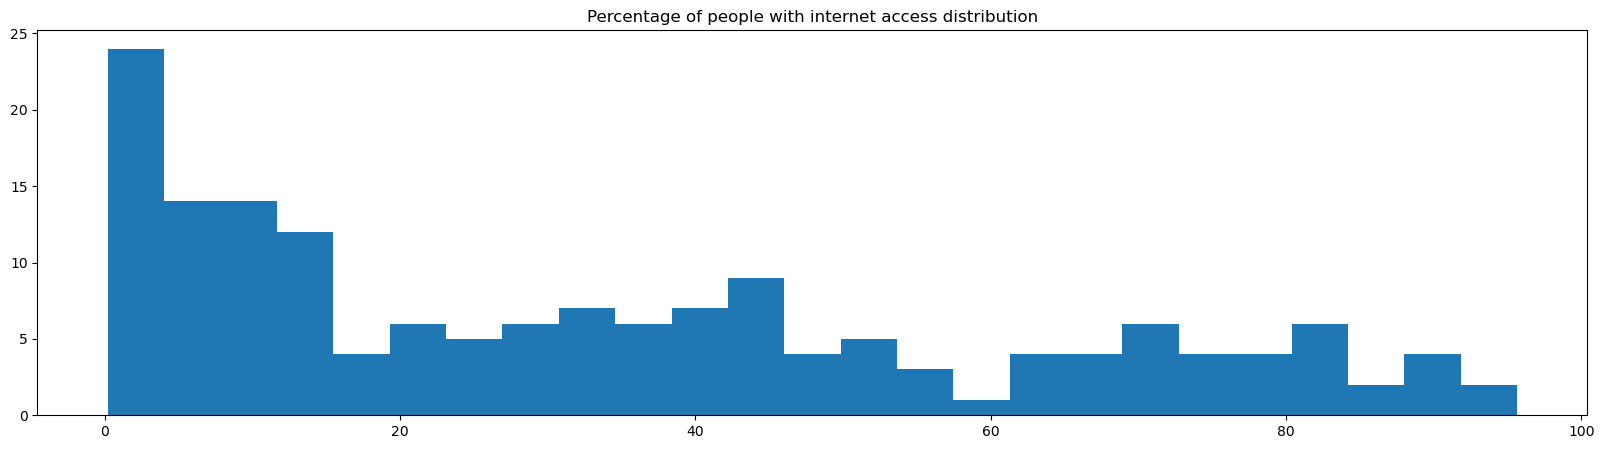

In [287]:
plt.figure(figsize=(20, 5))
plt.hist(df_new['perc_users_with_internet'], bins=25)
plt.title("Percentage of people with internet access distribution")
plt.plot()

[]

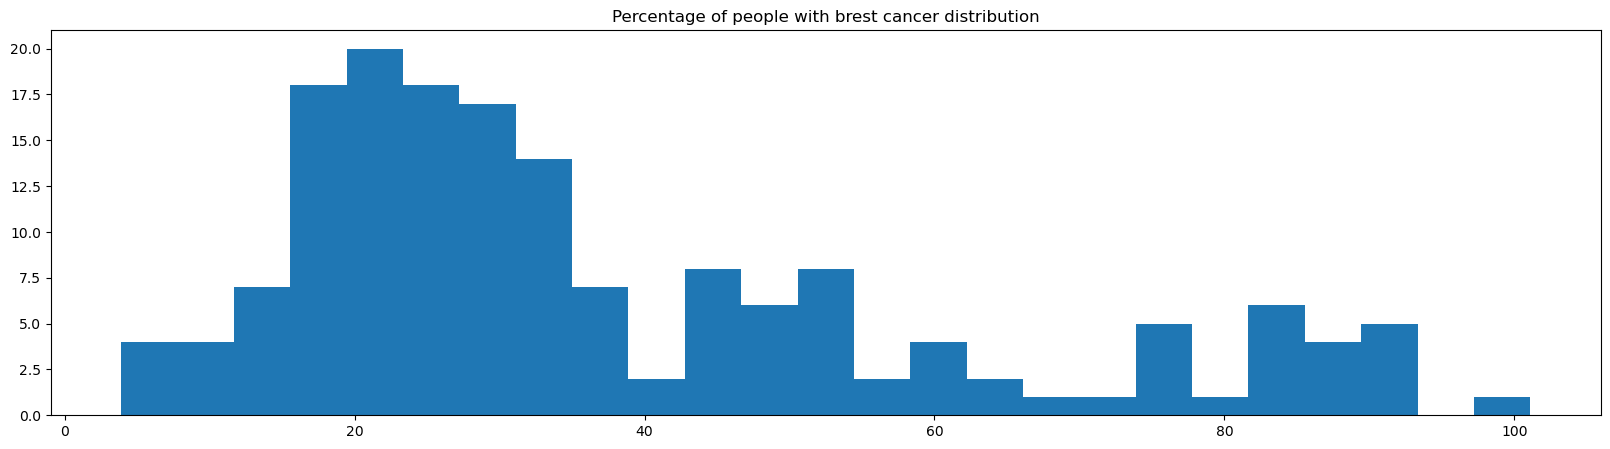

In [288]:
plt.figure(figsize=(20, 5))
plt.hist(df_new['perc_brest_cancer'], bins=25)
plt.title("Percentage of people with brest cancer distribution")
plt.plot()

Cabe aclarar que se observan valores mayores a 100 porque el campo de personas con cáncer de mama representa cuántas personas de cada 100.000 tienen este tipo de cáncer.

[]

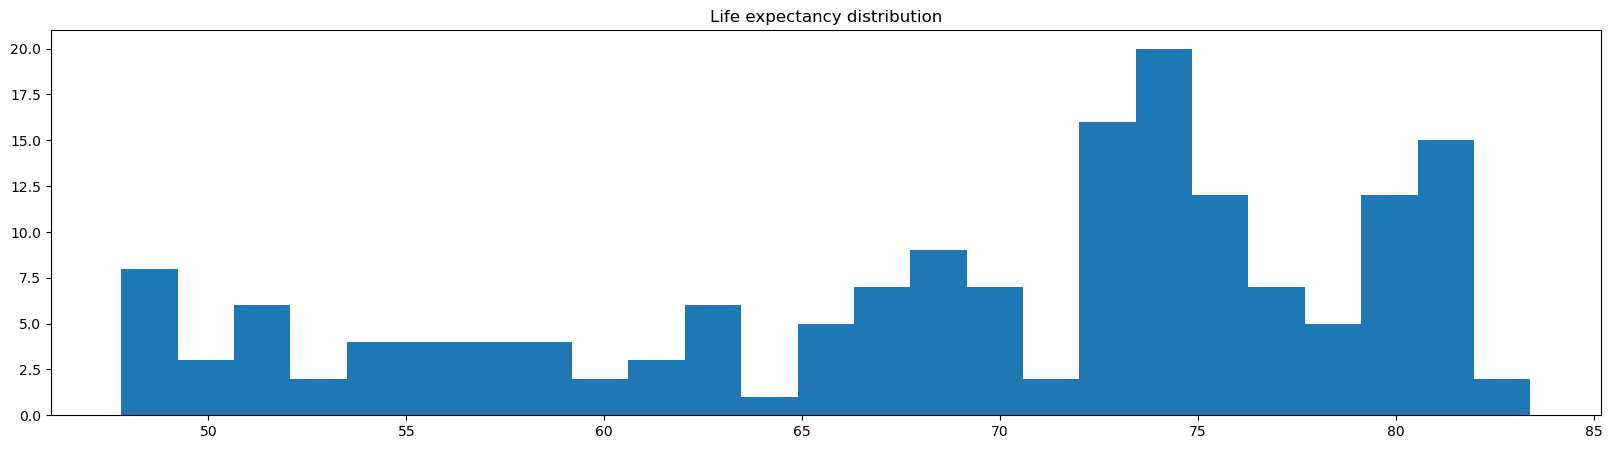

In [289]:
plt.figure(figsize=(20, 5))
plt.hist(df_new['life_expectancy'], bins=25)
plt.title("Life expectancy distribution")
plt.plot()

[]

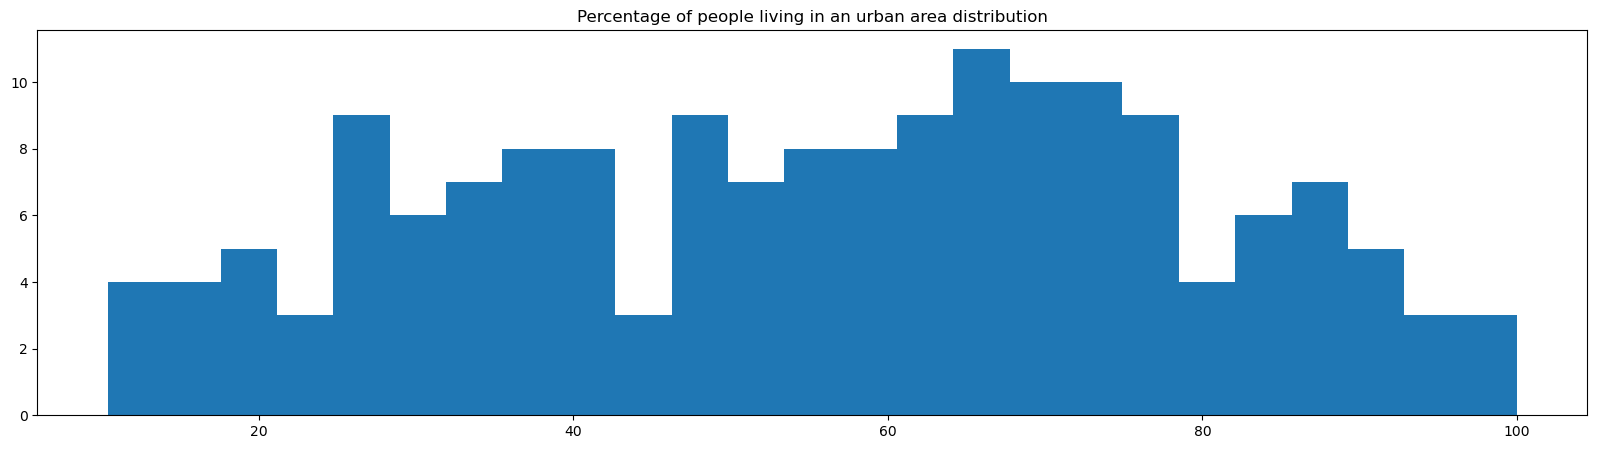

In [290]:
plt.figure(figsize=(20, 5))
plt.hist(df_new['perc_urban'], bins=25)
plt.title("Percentage of people living in an urban area distribution")
plt.plot()

[]

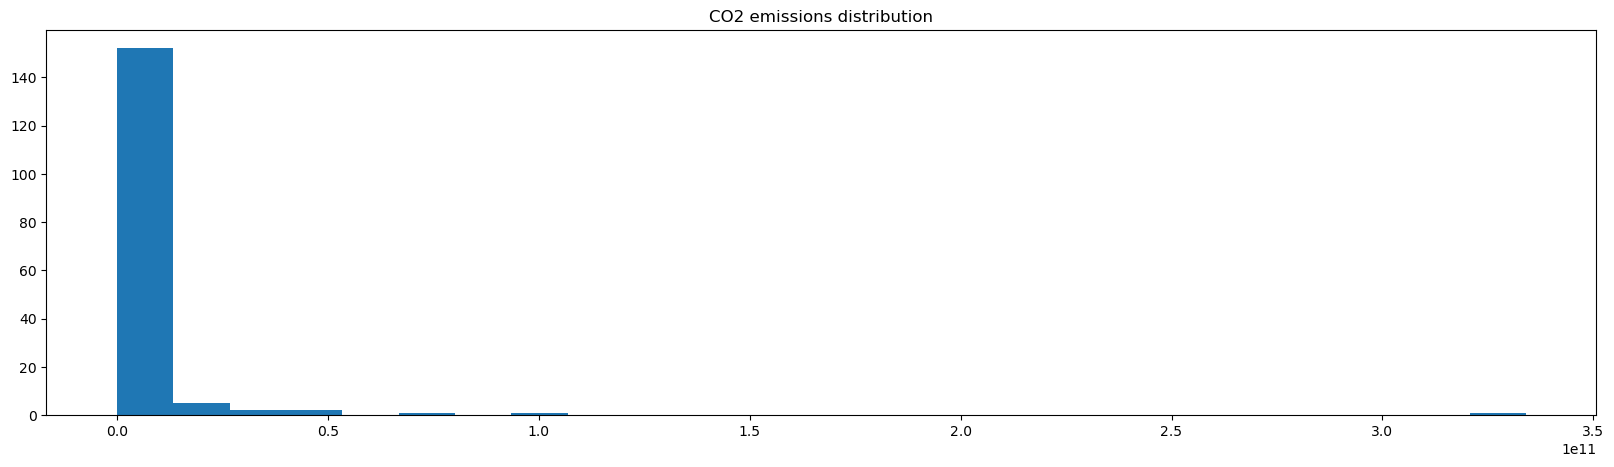

In [291]:
plt.figure(figsize=(20, 5))
plt.hist(df_new['co2_emissions'], bins=25)
plt.title("CO2 emissions distribution")
plt.plot()

Esta última feature es la única para la cual identificamos un valor atípico, por lo que procedemos a realizar el juste por medio de los cuantiles.

In [292]:
q1_r = df_new['co2_emissions'].quantile(0.25)
q3_r = df_new['co2_emissions'].quantile(0.75)
iqr_co2_emissions = q3_r - q1_r

[]

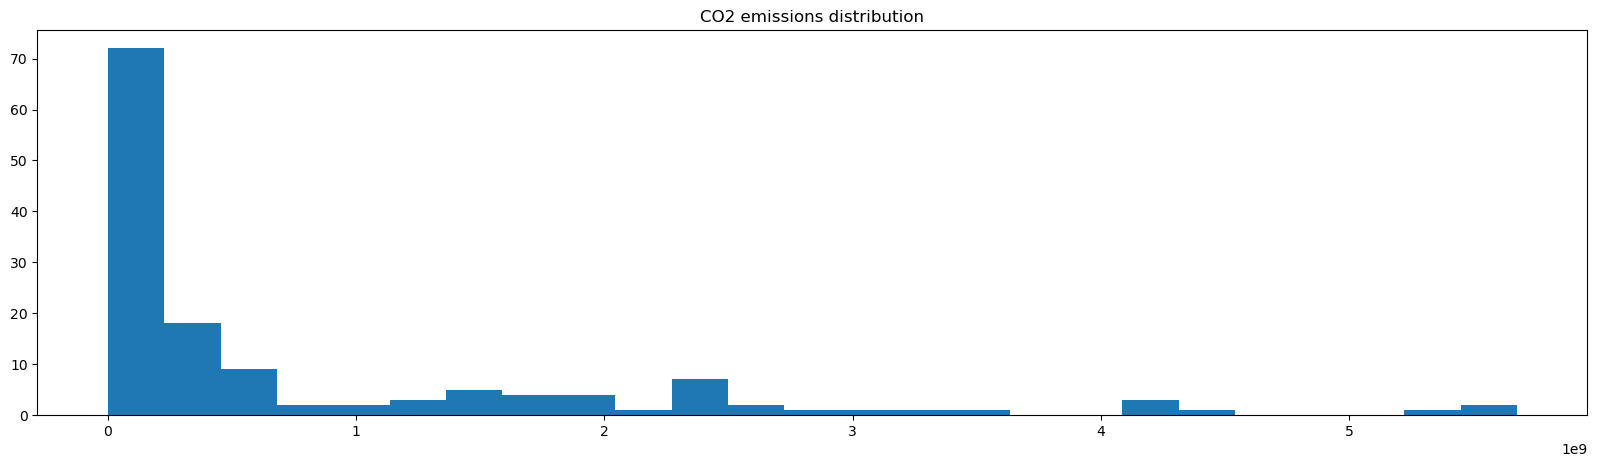

In [293]:
plt.figure(figsize=(20, 5))
plt.hist(df_new.loc[df_new['co2_emissions'] <= (q3_r + 1.5 * iqr_co2_emissions)]['co2_emissions'], bins=25)
plt.title("CO2 emissions distribution")
plt.plot()

Dado que la distribució de esta feature está bastante sesgada, se toma la decisión de cambiarla por "owid_education_index", a pesar de que tiene un 7% de valores nulos, dado que su correlación con el PIB es casi del doble que la siguiente feature posible a utilizar.

[]

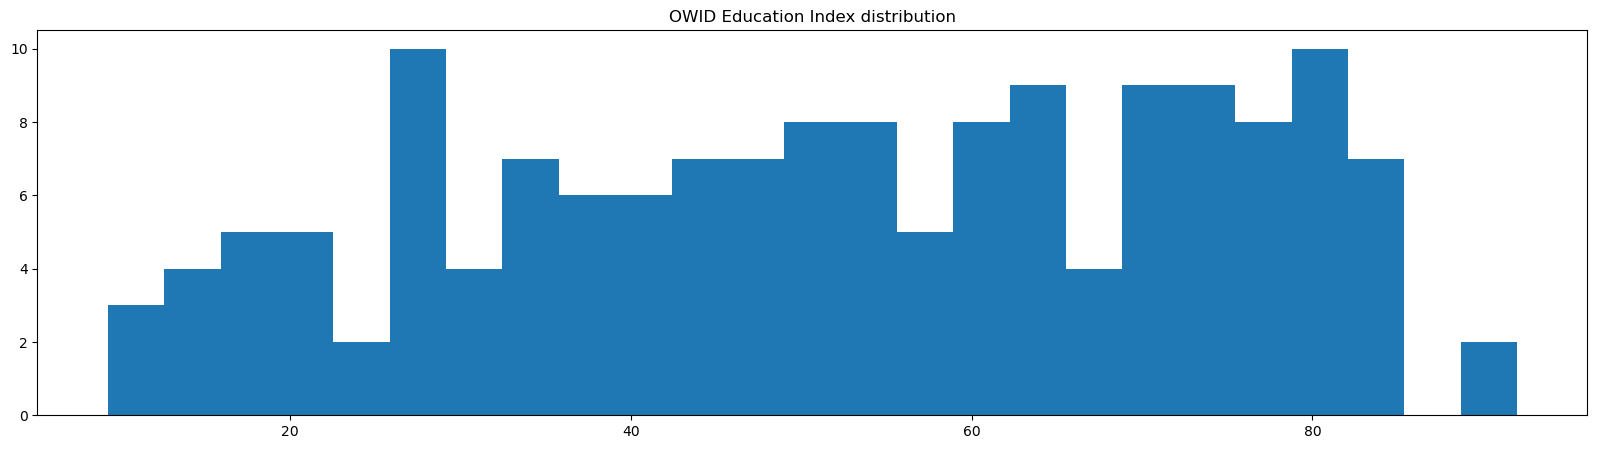

In [294]:
plt.figure(figsize=(20, 5))
plt.hist(df_new['owid_education_index'], bins=25)
plt.title("OWID Education Index distribution")
plt.plot()

# Análisis bivariado

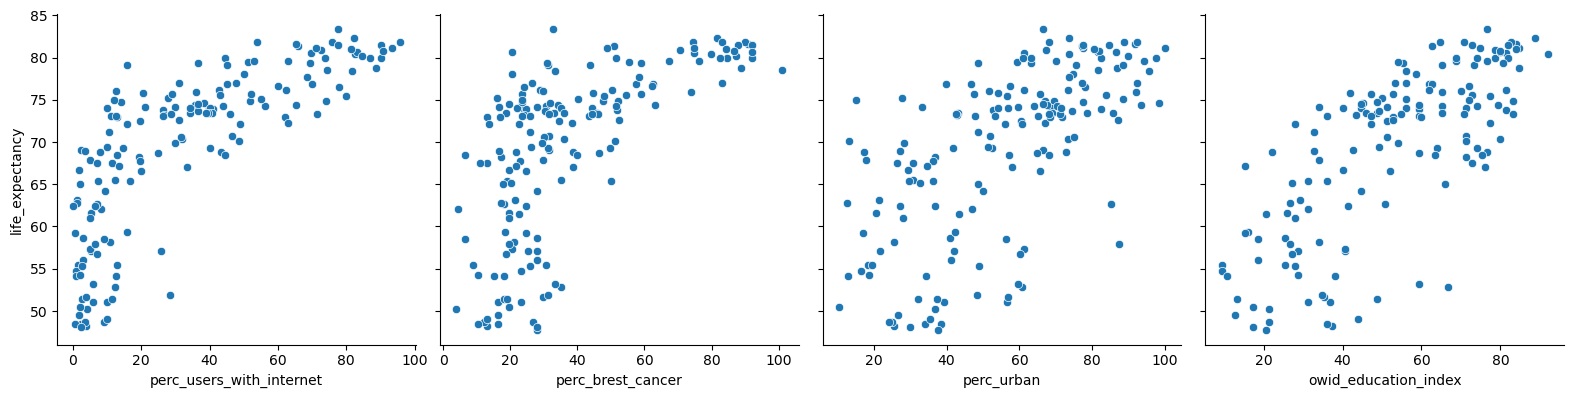

In [295]:
features_final = ["perc_users_with_internet"
                  , "perc_brest_cancer"
                  , "perc_urban"
                  , "owid_education_index"]
sns.pairplot(df_new, height=4, y_vars="life_expectancy", x_vars=features_final, kind="scatter")

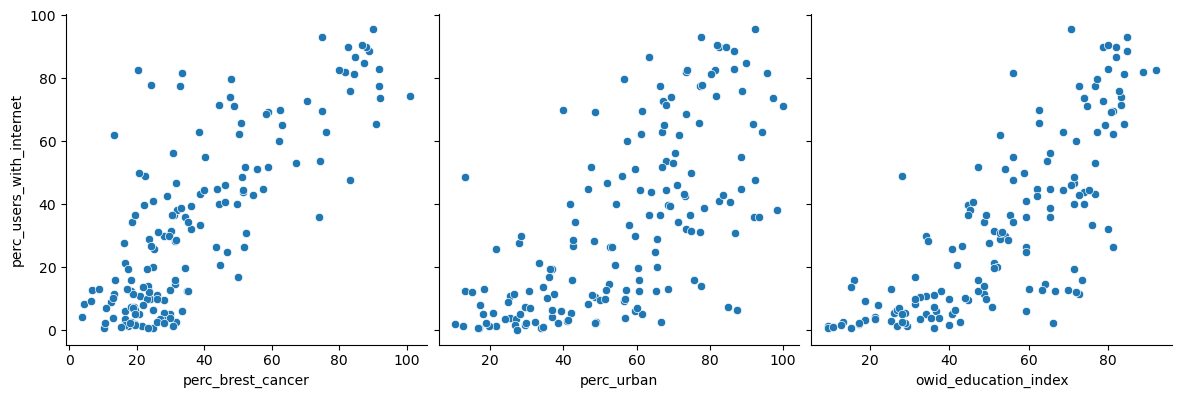

In [296]:
features_final = ["perc_brest_cancer"
                  , "perc_urban"
                  , "owid_education_index"]
sns.pairplot(df_new, height=4, y_vars="perc_users_with_internet", x_vars=features_final, kind="scatter")

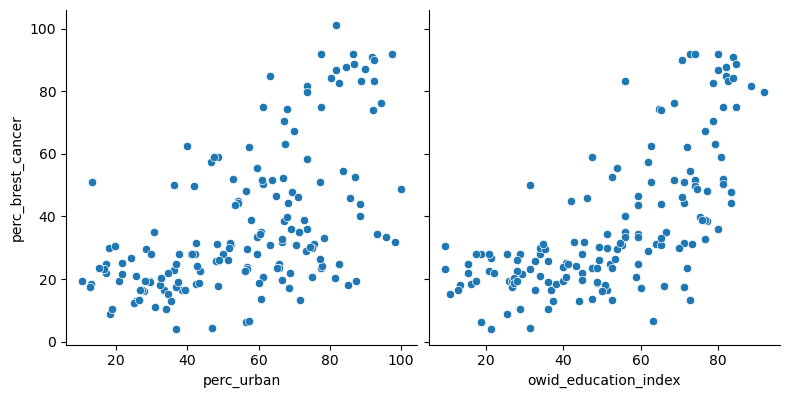

In [297]:
features_final = ["perc_urban"
                  , "owid_education_index"]
sns.pairplot(df_new, height=4, y_vars="perc_brest_cancer", x_vars=features_final, kind="scatter")

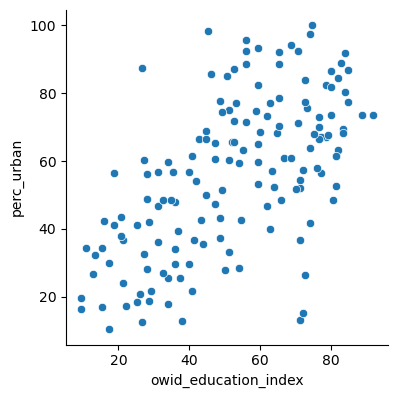

In [298]:
features_final = ["owid_education_index"]
sns.pairplot(df_new, height=4, y_vars="perc_urban", x_vars=features_final, kind="scatter")

# 2. Preparación y limpieza de datos

In [457]:
columns = ["country"
          ,"pib_per_person"
          ,"alcohol_consumption_per_person"
          ,"perc_armed_force"
          ,"perc_brest_cancer"
          ,"co2_emissions"
          ,"perc_female_employ"
          ,"perc_VIH"
          ,"perc_users_with_internet"
          ,"life_expectancy"
          ,"oil_per_person"
          ,"polity_score"
          ,"electric_consumption_per_person"
          ,"perc_suicide"
          ,"perc_employ"
          ,"perc_urban"
          ,"owid_education_index"]

In [458]:
list_nulls = df_new[columns].isnull().sum() / df_new.shape[0]
list_nulls

country                            0.000000
pib_per_person                     0.000000
alcohol_consumption_per_person     0.000000
perc_armed_force                   0.000000
perc_brest_cancer                  0.000000
co2_emissions                      0.000000
perc_female_employ                 0.000000
perc_VIH                           0.132530
perc_users_with_internet           0.000000
life_expectancy                    0.000000
oil_per_person                     0.632530
polity_score                       0.000000
electric_consumption_per_person    0.216867
perc_suicide                       0.000000
perc_employ                        0.000000
perc_urban                         0.000000
owid_education_index               0.000000
dtype: float64

Antes de pensar en la limpieza de datos o imputación, revisamos el porcentaje de valores nulos de cada feature, con esto, realizamos el primer filtro, dado que si una variable tiene más del 7-8 % no vale la pena pensar en imputar datos, no es posible porque sería una cantidad muy elevada.

In [459]:
final_features = []
for i in range(0, len(columns)):
    if list_nulls[i] <= 0.08:
        final_features.append(columns[i])
        print(columns[i], list_nulls[i])
    

country 0.0
pib_per_person 0.0
alcohol_consumption_per_person 0.0
perc_armed_force 0.0
perc_brest_cancer 0.0
co2_emissions 0.0
perc_female_employ 0.0
perc_users_with_internet 0.0
life_expectancy 0.0
polity_score 0.0
perc_suicide 0.0
perc_employ 0.0
perc_urban 0.0
owid_education_index 0.0


In [460]:
final_features

['country',
 'pib_per_person',
 'alcohol_consumption_per_person',
 'perc_armed_force',
 'perc_brest_cancer',
 'co2_emissions',
 'perc_female_employ',
 'perc_users_with_internet',
 'life_expectancy',
 'polity_score',
 'perc_suicide',
 'perc_employ',
 'perc_urban',
 'owid_education_index']

Al contar con un data set tan pequeño, no implementaremos la eliminación de valores nulos, optaremos por una imputación por la mediana. Se toma la decisión dado que no estamos seguros de que la distribución de todas las features sea normal para usar la media, además, la media también se ve afectada por valores atípicos.

In [461]:
final_features = final_features[1:]
final_features

['pib_per_person',
 'alcohol_consumption_per_person',
 'perc_armed_force',
 'perc_brest_cancer',
 'co2_emissions',
 'perc_female_employ',
 'perc_users_with_internet',
 'life_expectancy',
 'polity_score',
 'perc_suicide',
 'perc_employ',
 'perc_urban',
 'owid_education_index']

In [462]:
for i in final_features:
    df_new[i].fillna(df_new[i].median(), inplace=True)

In [463]:
df_new.head()

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_VIH,perc_users_with_internet,life_expectancy,oil_per_person,polity_score,electric_consumption_per_person,perc_suicide,perc_employ,perc_urban,gini_coefficient,corruption_index,perc_unemployment,population_density,owid_education_index,population
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,0.2,69.770394,80.557,1.700262,10.0,2051.802338,10.365070,59.900002,61.34,30.1,8.0,14.50,66.2,81.3,4520000.0
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,NaN,44.989947,76.918,NaN,9.0,636.341383,7.699330,51.400002,46.72,29.5,3.3,14.10,106.0,62.0,2910000.0
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,4.7,2.300027,48.398,NaN,-1.0,NaN,13.548420,71.300003,38.58,NaN,NaN,NaN,NaN,52.7,NaN
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,1.4,70.028599,76.835,NaN,6.0,NaN,3.108603,66.900002,39.84,54.5,7.8,10.70,639.0,62.7,275000.0
4,Italy,18982.269290,9.72,1.729346,74.4,1.900045e+10,35.799999,0.3,53.740217,81.855,1.207250,10.0,1176.385457,4.930045,46.400002,68.08,34.7,3.9,8.36,202.0,64.7,59800000.0


In [464]:
df_final = df_new.copy()
df_final = df_final.loc[:, ['country'] + final_features]
df_final.head()
df_final.shape

(166, 14)

In [465]:
df_final[final_features].isnull().sum() / df_final.shape[0]

pib_per_person                    0.0
alcohol_consumption_per_person    0.0
perc_armed_force                  0.0
perc_brest_cancer                 0.0
co2_emissions                     0.0
perc_female_employ                0.0
perc_users_with_internet          0.0
life_expectancy                   0.0
polity_score                      0.0
perc_suicide                      0.0
perc_employ                       0.0
perc_urban                        0.0
owid_education_index              0.0
dtype: float64

# Añadiendo variable categórica

In [466]:
continentes = pd.read_csv("./data/paises.csv")
continentes

,nombre,name,nom,iso2,iso3,phone_code,continente
0,Afganistán,Afghanistan,Afghanistan,AF,AFG,93,Asia
1,Albania,Albania,Albanie,AL,ALB,355,Europa
2,Alemania,Germany,Allemagne,DE,DEU,49,Europa
3,Algeria,Algeria,Algérie,DZ,DZA,213,África
4,Andorra,Andorra,Andorra,AD,AND,376,Europa
...,...,...,...,...,...,...,...
241,Wallis y Futuna,Wallis and Futuna,Wallis et Futuna,WF,WLF,681,Australia y Oceanía
242,Yemen,Yemen,Yémen,YE,YEM,967,Asia
243,Yibuti,Djibouti,Djibouti,DJ,DJI,253,África
244,Zambia,Zambia,Zambie,ZM,ZMB,260,África


In [467]:
continentes = continentes.loc[:, [' name', 'continente']]
continentes

,name,continente
0,Afghanistan,Asia
1,Albania,Europa
2,Germany,Europa
3,Algeria,África
4,Andorra,Europa
...,...,...
241,Wallis and Futuna,Australia y Oceanía
242,Yemen,Asia
243,Djibouti,África
244,Zambia,África


Vamos a utilizar este dataset como diccionario para obtener el continente

In [468]:
df_final.shape

(166, 14)

In [469]:
df_final = pd.merge(df_final, continentes, left_on='country', right_on=' name', how='left')

In [470]:
df_final.shape

(166, 16)

In [471]:
df_final = df_final.drop(' name', axis=1)

In [472]:
df_final.head()

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_users_with_internet,life_expectancy,polity_score,perc_suicide,perc_employ,perc_urban,owid_education_index,continente
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,69.770394,80.557,10.0,10.365070,59.900002,61.34,81.3,Europa
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,44.989947,76.918,9.0,7.699330,51.400002,46.72,62.0,Europa
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,2.300027,48.398,-1.0,13.548420,71.300003,38.58,52.7,NaN
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,70.028599,76.835,6.0,3.108603,66.900002,39.84,62.7,América
4,Italy,18982.269290,9.72,1.729346,74.4,1.900045e+10,35.799999,53.740217,81.855,10.0,4.930045,46.400002,68.08,64.7,Europa


In [473]:
df_final.shape

(166, 15)

In [474]:
df_final[df_final['continente'].isnull()]

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_users_with_internet,life_expectancy,polity_score,perc_suicide,perc_employ,perc_urban,owid_education_index,continente
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,2.300027,48.398,-1.0,13.548420,71.300003,38.58,52.7,NaN
18,"Macedonia, FYR",2221.185664,8.94,2.101467,52.1,1.688830e+08,26.799999,51.914184,74.847,9.0,7.876878,34.900002,66.90,52.7,NaN
23,"Korea, Rep.",16372.499780,19.15,2.833966,20.4,9.666892e+09,48.000000,82.515928,80.642,8.0,22.404560,58.900002,81.46,52.7,NaN
44,"Yemen, Rep.",610.357367,0.20,2.316235,35.1,2.348647e+08,20.299999,12.349750,65.493,-2.0,6.265789,39.000000,30.64,52.7,NaN
75,Slovak Republic,8445.526689,13.31,0.628578,48.0,5.906743e+08,45.299999,79.889777,75.446,10.0,10.645740,53.400002,56.56,77.3,NaN
89,"Congo, Dem. Rep.",103.775857,3.39,0.628381,10.3,1.691800e+08,50.400002,0.720009,48.397,5.0,14.713020,66.199997,33.96,36.0,NaN
103,"Congo, Rep.",1253.292015,4.46,0.771694,20.6,4.630633e+07,52.299999,4.999875,57.379,-4.0,9.873761,64.199997,61.34,40.7,NaN
109,Dominican Rep.,4049.169629,6.28,1.469369,36.1,4.463653e+08,40.500000,39.531274,73.396,8.0,6.519537,52.700001,69.02,52.7,NaN
136,Cote d'Ivoire,591.067944,6.47,0.233915,26.0,2.287487e+08,38.099998,2.599974,55.377,0.0,20.317930,59.900002,48.78,28.0,NaN
146,Czech Rep.,7381.312751,16.47,0.515706,58.4,1.776016e+09,47.599998,68.638133,77.685,8.0,12.367980,56.000000,73.50,52.7,NaN


In [475]:
paises_sin_continente = df_final['country'][df_final['continente'].isnull()].tolist()
paises_sin_continente

['Central African Rep.',
 'Macedonia, FYR',
 'Korea, Rep.',
 'Yemen, Rep.',
 'Slovak Republic',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Dominican Rep.',
 "Cote d'Ivoire",
 'Czech Rep.',
 'Timor-Leste',
 'United States']

In [476]:
diccionario_correccion = {'Central African Rep.': 'África',
 'Macedonia, FYR': 'Europa',
 'Korea, Rep.': 'Asia',
 'Yemen, Rep.': 'África',
 'Slovak Republic': 'Europa',
 'Congo, Dem. Rep.': 'África',
 'Congo, Rep.': 'África',
 'Dominican Rep.': 'América',
 "Cote d'Ivoire": 'África',
 'Czech Rep.': 'Europa',
 'Timor-Leste': 'Asia',
 'United States': 'América'}

In [477]:
for i in paises_sin_continente:
    df_final.loc[df_final['country'] == i, 'continente'] = diccionario_correccion[i]

In [478]:
df_final[df_final['continente'].isnull()]

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_users_with_internet,life_expectancy,polity_score,perc_suicide,perc_employ,perc_urban,owid_education_index,continente


# 3. Entrenamiento del modelo

In [525]:
df_model = df_final.copy()
df_model.head()

,country,pib_per_person,alcohol_consumption_per_person,perc_armed_force,perc_brest_cancer,co2_emissions,perc_female_employ,perc_users_with_internet,life_expectancy,polity_score,perc_suicide,perc_employ,perc_urban,owid_education_index,continente
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,69.770394,80.557,10.0,10.365070,59.900002,61.34,81.3,Europa
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,44.989947,76.918,9.0,7.699330,51.400002,46.72,62.0,Europa
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,2.300027,48.398,-1.0,13.548420,71.300003,38.58,52.7,África
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,70.028599,76.835,6.0,3.108603,66.900002,39.84,62.7,América
4,Italy,18982.269290,9.72,1.729346,74.4,1.900045e+10,35.799999,53.740217,81.855,10.0,4.930045,46.400002,68.08,64.7,Europa


In [526]:
features_relevantes= ['perc_users_with_internet'
                      ,'perc_brest_cancer'
                      ,'life_expectancy'
                      ,'perc_urban'
                      ,'owid_education_index'
                      ,'continente']

In [527]:
df_model = df_final.loc[:, ['pib_per_person'] + features_relevantes]

In [530]:
df_model.head()

,pib_per_person,perc_users_with_internet,perc_brest_cancer,life_expectancy,perc_urban,owid_education_index,continente
0,27595.091350,69.770394,74.9,80.557,61.34,81.3,Europa
1,1914.996551,44.989947,57.4,76.918,46.72,62.0,Europa
2,239.518749,2.300027,16.5,48.398,38.58,52.7,África
3,9243.587053,70.028599,62.5,76.835,39.84,62.7,América
4,18982.269290,53.740217,74.4,81.855,68.08,64.7,Europa


In [532]:
df_model.shape

(166, 7)

In [533]:
df_model = pd.get_dummies(df_model, columns=['continente'], prefix=['continente'])
df_model.head()

,pib_per_person,perc_users_with_internet,perc_brest_cancer,life_expectancy,perc_urban,owid_education_index,continente_América,continente_Asia,continente_Australia y Oceanía,continente_Europa,continente_África
0,27595.091350,69.770394,74.9,80.557,61.34,81.3,0,0,0,1,0
1,1914.996551,44.989947,57.4,76.918,46.72,62.0,0,0,0,1,0
2,239.518749,2.300027,16.5,48.398,38.58,52.7,0,0,0,0,1
3,9243.587053,70.028599,62.5,76.835,39.84,62.7,1,0,0,0,0
4,18982.269290,53.740217,74.4,81.855,68.08,64.7,0,0,0,1,0


In [534]:
features_relevantes= ['perc_users_with_internet'
                      ,'perc_brest_cancer'
                      ,'life_expectancy'
                      ,'perc_urban'
                      ,'owid_education_index'
                      ,'continente_América'
                      ,'continente_Asia'
                      ,'continente_Australia y Oceanía'
                      ,'continente_Europa'
                      ,'continente_África']

In [543]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_model)
df_normalized = pd.DataFrame(df_normalized, columns=df_model.columns)
df_normalized.head()

,pib_per_person,perc_users_with_internet,perc_brest_cancer,life_expectancy,perc_urban,owid_education_index,continente_América,continente_Asia,continente_Australia y Oceanía,continente_Europa,continente_África
0,1.976418,1.311743,1.637108,1.151482,0.237252,1.405697,-0.460086,-0.600546,-0.176227,1.867214,-0.665942
1,-0.501731,0.413977,0.873050,0.785621,-0.404670,0.465914,-0.460086,-0.600546,-0.176227,1.867214,-0.665942
2,-0.663416,-1.132628,-0.912660,-2.081743,-0.762074,0.013065,-0.460086,-0.600546,-0.176227,-0.535557,1.501633
3,0.205484,1.321097,1.095719,0.777276,-0.706751,0.499999,2.173508,-0.600546,-0.176227,-0.535557,-0.665942
4,1.145274,0.730989,1.615278,1.281981,0.533186,0.597386,-0.460086,-0.600546,-0.176227,1.867214,-0.665942


In [544]:
X_train, X_test, y_train, y_test = train_test_split(df_normalized[features_relevantes], df_normalized["pib_per_person"], test_size=0.3, random_state=1)

In [545]:
X_train.shape, y_train.shape

((116, 10), (116,))

In [546]:
X_test.shape, y_test.shape

((50, 10), (50,))

In [547]:
regression = LinearRegression()

In [548]:
regression.fit(X_train, y_train)

LinearRegression()

In [549]:
pd.DataFrame({"columns": features_relevantes, "coef": regression.coef_})

,columns,coef
0,perc_users_with_internet,0.507629
1,perc_brest_cancer,0.328869
2,life_expectancy,0.048188
3,perc_urban,0.106725
4,owid_education_index,-0.081283
5,continente_América,-0.023909
6,continente_Asia,0.038911
7,continente_Australia y Oceanía,0.007359
8,continente_Europa,-0.139426
9,continente_África,0.105504


In [550]:
regression.intercept_

-0.08001664877240364

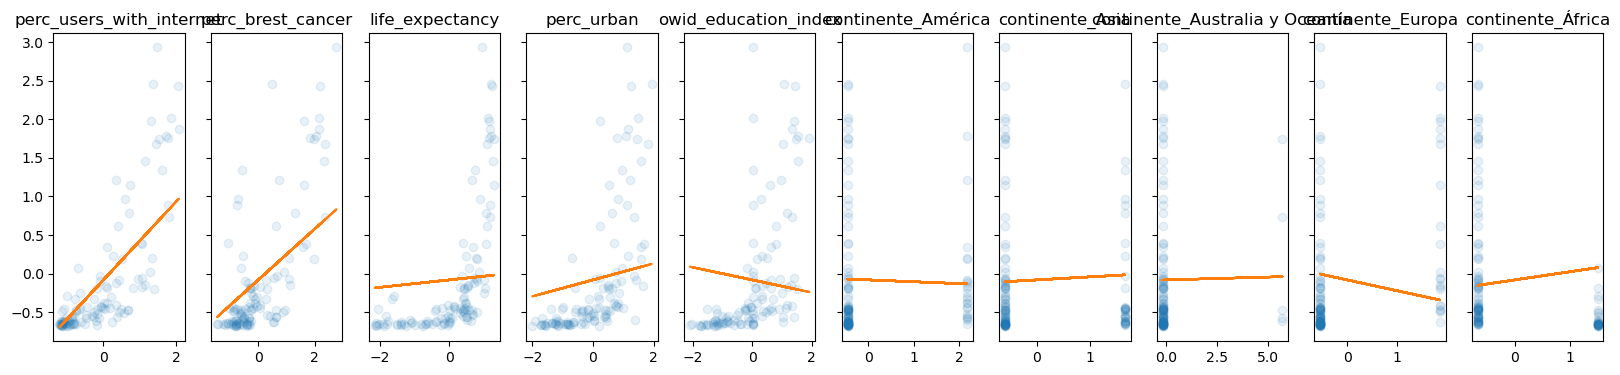

In [552]:
f, axs = plt.subplots(1, len(features_relevantes), sharey=True, figsize=(20, 4))

for i in range(len(features_relevantes)):
    col = features_relevantes[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Para analizar los coeficientes obtenidos para las features analizadas debemos tener en cuenta que:
1) El signo del coeficiente representa la dirección de la relación entre la variable de entrada correspondiente y la variable objetivo. Signos positivos implican que si el valor de la variable de entada aumenta, el valor de la variable objetivo también aumentará, mientras que signos negativos indican que si el valor de la variable de entrada aumenta, el valor de la variable objetivo disminuirá.
2) El valor del coeficiente cuantifica la magnitud de la relación, implicando que un aumento o disminución (dependiendo del signo del coeficiente) en una unidad de la variable de entrada representará un cambio equivalente al valor del coeficiente en la variable objetivo, asumiendo que los valores de las demás variables de entrada permanezcan constantes.

**De esta manera tenemos que:**

Hay 5 variables que tienen un impacto mayor al 10% sobre el PIB, estas son:
- perc_users_with_internet	0.507629
- perc_brest_cancer	0.328869
- perc_urban	0.106725
- continente_Europa	-0.139426
- continente_África	0.105504

Sin embargo, las gráficas para cada variable muestran que claramente las features de mayor impacto son **perc_users_with_internet y perc_brest_cancer**. Las features que representan la ubicación geográfica no varían mucho, por lo que quizás este indicador no sea de mucha utilidad.

# 4. Resultados

In [553]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 0.329564068136533
Test: 0.5176859740917288


In [554]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 0.4358905525755858
Test: 0.804271434621875


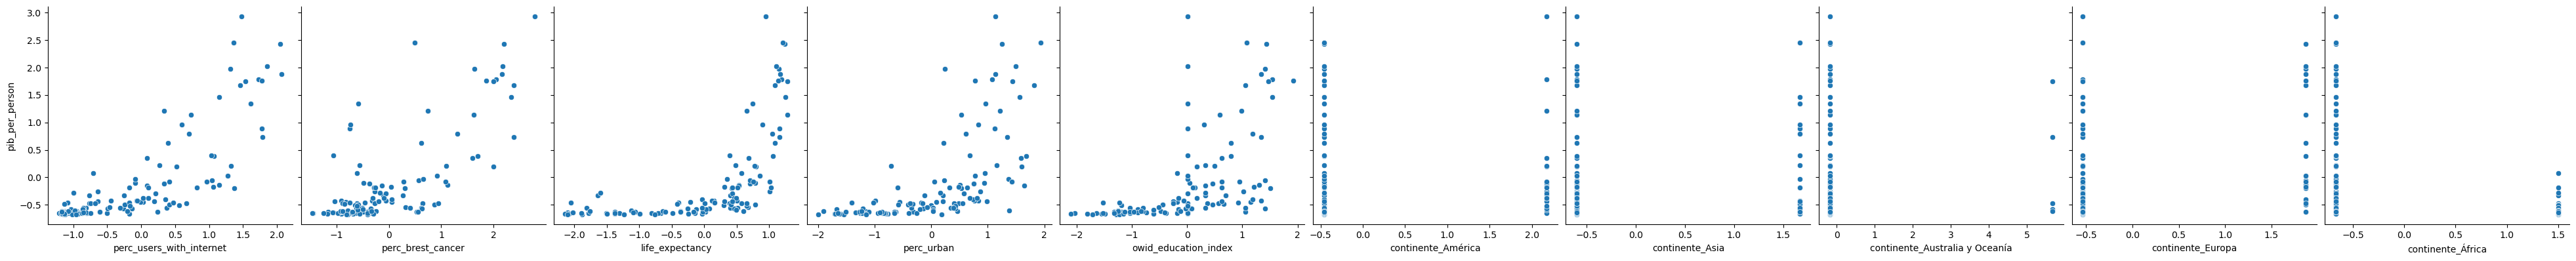

In [559]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars="pib_per_person", x_vars=features_relevantes, kind="scatter")

Dado que se aplicó una normalización de los datos utilizando z-score, los errores obtenidos no son tan elevados, pues la normalización acerca todos los valores a 0, con una desviación de más o menos 1.
Por otro lado, los principales insights obtenidos son las variables más relevantes o influyentes para el desempeño o comportamiento del PIB, las cuales son **perc_users_with_internet y perc_brest_cancer**. De esta manera, las políticas públicas que se recomiendan implemtar son aquellas enfocadas en desarrollo tecnológico y políticas de salud pública, con el fin de mejorar los indicadores más influyentes en el PIB y asegurar que el país sea estable, para obtener apoyo financiero del Banco Mundial.